# Matrix Encoding and Permanent Estimation

This notebook is part of a series of notebooks with the code to reproduce results from this [REFERENCE] paper. Similarly to notebook 1 for Matrix Encoding, this $5^{th}$ notebook also contains the initial steps for the encoding function *to_unitary()* and permanent estimation. However, here we use Quandela's QPU (Ascella) to run the algorithm and perform our estimations. In order to do that, the notebook is organised as follows:
- *to_unitary()* function
- State preparation and post-selection.
- *perm_estimation()* function to estimate the permanent on the cloud.

To run these notebooks, you will need to install **Perceval**, a software tool developed by Quandela that we use to control the photonic device.

In [28]:
import numpy as np
from numpy import linalg
from scipy.linalg import sqrtm

import math
import networkx as nx
from datetime import datetime
import time

import perceval as pcvl
import perceval.components.unitary_components as comp

import quandelibc as qc
import matplotlib.pyplot as plt

In [140]:
from itertools import combinations

In [29]:
import functions

![BSdevice_graphs.png](attachment:BSdevice_graphs.png)

We construct *to_unitary()* now. Considering the singular value decomposition of $A$, from the theory part in the paper we have that if $$A=U\Sigma V^T \text{ and } s=\sigma_{max}(A)$$
then we can embed $A$ into a doubled-size unitary $U_A$ with the form:
$$U_A:=\begin{pmatrix}
A_s & \sqrt{I_{n \times n} -A_s(A_s)^{T}} \\
\sqrt{I_{n \times n} -(A_s)^{T}A_s}  & -(A_s)^{T}\\
\end{pmatrix}$$

In [30]:
def to_unitary(A):
    ''' Input: graph A either as:
                                 an adjacency matrix of size mxm
                                 a networkX graph with m nodes
        Output: unitary with size 2mx2m
    '''

    if type(A)==type(nx.Graph()):
        A=nx.convert_matrix.to_numpy_matrix(A)
    P,D,V=linalg.svd(A)
    
    c=np.max(D)
    An=np.matrix(A/c, dtype=complex)                       #if it is not complex, then np.sqrt will output nan in complex values
    P=An
    m=len(An)
    Q=sqrtm( np.identity(m)-np.dot(An,An.conj().T) )
    R=sqrtm( np.identity(m)-np.dot(An.conj().T,An) )
    S=-An.conj().T
    Ubmat=np.bmat([ [P, Q], [R, S] ])
    return (np.copy(Ubmat),c)

In [31]:
def input_state(m):
    '''input state for selection of our m modes
        returns |1,1,1,...,0,0,0> m ones and m zeros'''
    return np.append(np.ones(m), np.zeros(m)).astype(int)

input_state(4)

array([1, 1, 1, 1, 0, 0, 0, 0])

In [141]:
#Post selection of samples with photons only on first half modes
def post_select(samples):
    ''''post select on states that have all modes from m to 2*m as vacuum
        can't have collision of first half'''
    a = []
    print(samples)
    m = int(len(samples[0])/2)
    for state in samples:
        state=list(state)
        if all(ele==state[m-1] for ele in state[:m]) and state[m-1]==1:
            a.append( state )                  #do not need to check if there is vaccum in the second half for several reasons!
    return a

Computing the permanent estimation by generating samples.

$$permE(A)=s^n PermE(A_s)=s^n\sqrt{\frac{ \text{Accepted samples} }{\text{Total number of samples}}}$$

In [142]:
qpu_token = 'YOUR_TOKEN'

In [144]:
def post_select_new(results):
    ''''post select on states that have all modes from m to 2*m as vacuum
        can't have collision of first half'''
    new_res = {}#; nb_samples_total = 0
    m = int( len(list(results.keys())[0])/2 )

    for sample in results:
        state=list(sample)
        if all(ele == state[m-1] for ele in state[:m]) and state[m-1] == 1:
            new_res[tuple(sample)]=results[sample]
            #nb_samples_total = nb_samples_total + results[sample]
    #print("list(new_res.values())[0]", list(new_res.values())[0])
    return new_res

In [145]:
def perm_naive(array):
    if np.array(array).size == 1:
        return np.array(array)[0, 0]
    else:
        return sum(
            array[i, 0]
            * perm_naive(np.array([array[j, 1:] for j in range(array.shape[0]) if j != i]))
            for i in range(array.shape[0])
        )

In [146]:
def no_bunching_proba_n_photons(V_fill, m, n):
    proba_n_photons = 0
    sub_mat_col = V_fill[:, list(range(n))]
    for indices_tuple in combinations(range(m), n):
        sub_matrix = sub_mat_col[list(indices_tuple), :]
        proba_n_photons += np.abs(perm_naive(sub_matrix)) ** 2
    return proba_n_photons

In [155]:
def perm_estimation(G, n_samples):
    '''Permanent estimation function for a given graph
    Arguments:
        G - networkX graph
        n_samples - number of samples to ask from the QPU
    '''
    m = G.number_of_nodes()
    input_fock = input_state(m)

    processor = pcvl.RemoteProcessor("qpu:ascella", qpu_token)
    processor.with_input(pcvl.BasicState(input_fock))

    circuit = pcvl.Circuit(2*m)
    U,c = functions.to_unitary(G)
    #U_bunching to correct the permanent below because of device errors like G2, loss, distinguishability (...)
    U_bunching = no_bunching_proba_n_photons(U, 2*m, m) 
    circuit.add(0, comp.Unitary(pcvl.Matrix(U)))
    processor.set_circuit(circuit)

    sampler = pcvl.algorithm.Sampler(processor)
    remote_job = sampler.sample_count
    remote_job.name = "perm_estimation" + datetime.now().strftime("%Y%m%d_%H%M%S")
    remote_job.execute_async(n_samples)

    while not remote_job.is_complete:
        time.sleep(0.02)
    #print("Job is complete!")

    samples = remote_job.get_results()['results']; print(samples)
    samples_post_selected = post_select_new(samples)
    
    # Here, we don't have minimum amount of post-selected samples
    # in case the case where is zero, it's pointless to compute the permanent
    if samples_post_selected == {}: 
        print("No post selected samples")
        return 0
    
    nb_post_selected = list(samples_post_selected.values())[0]
    print("Number of samples post-selected:", nb_post_selected)
    perm = (c**m)*np.sqrt(U_bunching*nb_post_selected/n_samples)#/2 #(c**m)*np.sqrt(len(samples)/(Ns*i))
    return perm

Plotting estimation and exact value for permanent over different specific graphs.

In [166]:
G1 = nx.Graph()
G1.add_nodes_from([0, 1, 2, 3])
G1.add_edges_from([(0, 1), (0,2), (1, 3), (2, 3)])

G2 = nx.Graph()
G2.add_nodes_from([0, 1, 2, 3])
G2.add_edges_from([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3)])

G3 = nx.Graph()
G3.add_nodes_from([0, 1, 2, 3])
G3.add_edges_from([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)])

G4 = nx.Graph()
G4.add_nodes_from([0, 1, 2])
G4.add_edges_from([(0, 1), (0, 2), (1, 2)])

In [168]:
Ns = 10000
print(perm_estimation(G4, Ns), qc.permanent_cx(nx.to_numpy_array(G4)))

{
  |1,1,1,0,0,0>: 1588
  |1,1,0,1,0,0>: 165
  |1,1,0,0,1,0>: 170
  |1,1,0,0,0,1>: 102
  |1,0,1,1,0,0>: 95
  |1,0,1,0,1,0>: 98
  |1,0,1,0,0,1>: 125
  |1,0,0,1,1,0>: 838
  |1,0,0,1,0,1>: 721
  |1,0,0,0,1,1>: 259
  |0,1,1,1,0,0>: 102
  |0,1,1,0,1,0>: 146
  |0,1,1,0,0,1>: 172
  |0,1,0,1,1,0>: 905
  |0,1,0,1,0,1>: 150
  |0,1,0,0,1,1>: 717
  |0,0,1,1,1,0>: 211
  |0,0,1,1,0,1>: 657
  |0,0,1,0,1,1>: 884
  |0,0,0,1,1,1>: 2116
  |0,1,0,1,1,1>: 1
}
Number of samples post-selected: 1588
1.840579618851988 (2+0j)


In [157]:
Ns = 10000
print(perm_estimation(G1, Ns), qc.permanent_cx(nx.to_numpy_array(G1)))

{
  |1,1,1,1,0,0,0,0>: 1927
  |1,1,1,0,1,0,0,0>: 8
  |1,1,1,0,0,1,0,0>: 160
  |1,1,1,0,0,0,1,0>: 138
  |1,1,1,0,0,0,0,1>: 4
  |1,1,0,1,1,0,0,0>: 101
  |1,1,0,1,0,1,0,0>: 7
  |1,1,0,1,0,0,1,0>: 6
  |1,1,0,1,0,0,0,1>: 66
  |1,1,0,0,1,1,0,0>: 5
  |1,1,0,0,1,0,1,0>: 12
  |1,1,0,0,1,0,0,1>: 5
  |1,1,0,0,0,1,1,0>: 2
  |1,1,0,0,0,1,0,1>: 7
  |1,1,0,0,0,0,1,1>: 8
  |1,0,1,1,1,0,0,0>: 117
  |1,0,1,1,0,1,0,0>: 6
  |1,0,1,1,0,0,1,0>: 7
  |1,0,1,1,0,0,0,1>: 95
  |1,0,1,0,1,1,0,0>: 11
  |1,0,1,0,1,0,1,0>: 9
  |1,0,1,0,1,0,0,1>: 13
  |1,0,1,0,0,1,1,0>: 11
  |1,0,1,0,0,1,0,1>: 5
  |1,0,1,0,0,0,1,1>: 8
  |1,0,0,1,1,1,0,0>: 4
  |1,0,0,1,1,0,1,0>: 7
  |1,0,0,1,1,0,0,1>: 1768
  |1,0,0,1,0,1,0,1>: 8
  |1,0,0,1,0,0,1,1>: 5
  |1,0,0,0,1,1,1,0>: 1
  |1,0,0,0,1,1,0,1>: 142
  |1,0,0,0,1,0,1,1>: 146
  |1,0,0,0,0,1,1,1>: 5
  |0,1,1,1,1,0,0,0>: 15
  |0,1,1,1,0,1,0,0>: 136
  |0,1,1,1,0,0,1,0>: 154
  |0,1,1,1,0,0,0,1>: 8
  |0,1,1,0,1,1,0,0>: 2
  |0,1,1,0,1,0,1,0>: 3
  |0,1,1,0,0,1,1,0>: 2024
  |0,1,1,0,0,1,0,1>: 3


In [162]:
Ns = 10000
print(perm_estimation(G2, Ns), qc.permanent_cx(nx.to_numpy_array(G2)))

{
  |1,1,1,1,0,0,0,0>: 247
  |1,1,1,0,1,0,0,0>: 28
  |1,1,1,0,0,1,0,0>: 28
  |1,1,1,0,0,0,1,0>: 42
  |1,1,1,0,0,0,0,1>: 8
  |1,1,0,1,1,0,0,0>: 19
  |1,1,0,1,0,1,0,0>: 27
  |1,1,0,1,0,0,1,0>: 36
  |1,1,0,1,0,0,0,1>: 20
  |1,1,0,0,1,1,0,0>: 373
  |1,1,0,0,1,0,1,0>: 22
  |1,1,0,0,1,0,0,1>: 29
  |1,1,0,0,0,1,1,0>: 16
  |1,1,0,0,0,1,0,1>: 27
  |1,1,0,0,0,0,1,1>: 72
  |1,0,1,1,1,0,0,0>: 50
  |1,0,1,1,0,1,0,0>: 46
  |1,0,1,1,0,0,1,0>: 114
  |1,0,1,1,0,0,0,1>: 75
  |1,0,1,0,1,1,0,0>: 25
  |1,0,1,0,1,0,1,0>: 72
  |1,0,1,0,1,0,0,1>: 51
  |1,0,1,0,0,1,1,0>: 28
  |1,0,1,0,0,1,0,1>: 25
  |1,0,1,0,0,0,1,1>: 40
  |1,0,0,1,1,1,0,0>: 15
  |1,0,0,1,1,0,1,0>: 61
  |1,0,0,1,1,0,0,1>: 77
  |1,0,0,1,0,1,1,0>: 15
  |1,0,0,1,0,1,0,1>: 25
  |1,0,0,1,0,0,1,1>: 53
  |1,0,0,0,1,1,1,0>: 309
  |1,0,0,0,1,1,0,1>: 233
  |1,0,0,0,1,0,1,1>: 441
  |1,0,0,0,0,1,1,1>: 178
  |0,1,1,1,1,0,0,0>: 44
  |0,1,1,1,0,1,0,0>: 53
  |0,1,1,1,0,0,1,0>: 106
  |0,1,1,1,0,0,0,1>: 97
  |0,1,1,0,1,1,0,0>: 20
  |0,1,1,0,1,0,1,0>: 48
  |0,1,

In [163]:
Ns = 10000
print(perm_estimation(G3, Ns), qc.permanent_cx(nx.to_numpy_array(G3)))

{
  |1,1,1,1,0,0,0,0>: 320
  |1,1,1,0,1,0,0,0>: 32
  |1,1,1,0,0,1,0,0>: 25
  |1,1,1,0,0,0,1,0>: 30
  |1,1,1,0,0,0,0,1>: 39
  |1,1,0,1,1,0,0,0>: 31
  |1,1,0,1,0,1,0,0>: 25
  |1,1,0,1,0,0,1,0>: 35
  |1,1,0,1,0,0,0,1>: 14
  |1,1,0,0,1,1,0,0>: 239
  |1,1,0,0,1,0,1,0>: 27
  |1,1,0,0,1,0,0,1>: 14
  |1,1,0,0,0,1,1,0>: 12
  |1,1,0,0,0,1,0,1>: 10
  |1,1,0,0,0,0,1,1>: 31
  |1,0,1,1,1,0,0,0>: 31
  |1,0,1,1,0,1,0,0>: 26
  |1,0,1,1,0,0,1,0>: 27
  |1,0,1,1,0,0,0,1>: 17
  |1,0,1,0,1,1,0,0>: 40
  |1,0,1,0,1,0,1,0>: 214
  |1,0,1,0,1,0,0,1>: 16
  |1,0,1,0,0,1,1,0>: 20
  |1,0,1,0,0,1,0,1>: 52
  |1,0,1,0,0,0,1,1>: 23
  |1,0,0,1,1,1,0,0>: 15
  |1,0,0,1,1,0,1,0>: 23
  |1,0,0,1,1,0,0,1>: 171
  |1,0,0,1,0,1,1,0>: 47
  |1,0,0,1,0,1,0,1>: 21
  |1,0,0,1,0,0,1,1>: 39
  |1,0,0,0,1,1,1,0>: 292
  |1,0,0,0,1,1,0,1>: 234
  |1,0,0,0,1,0,1,1>: 254
  |1,0,0,0,0,1,1,1>: 200
  |0,1,1,1,1,0,0,0>: 23
  |0,1,1,1,0,1,0,0>: 25
  |0,1,1,1,0,0,1,0>: 26
  |0,1,1,1,0,0,0,1>: 14
  |0,1,1,0,1,1,0,0>: 22
  |0,1,1,0,1,0,1,0>: 16
  |0,1

Putting it all together for error estimation.


[0.185903200617956, 0.5002419881523076, 0.9411349531284028, 0.092951600308978]


<ErrorbarContainer object of 3 artists>

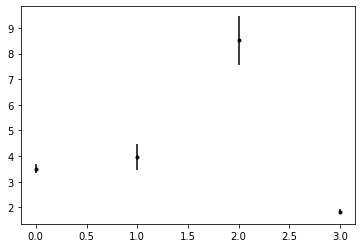

In [183]:
Ns = 10000
perm_error = []
#results = {graph: (number of post-selected samples, estimated permanent)}
results = {G1: (1927, 3.5118), G2: (247, 3.9667), G3: (320, 8.5124), G4: (1588, 1.8406)}

for G in results.keys():
    U,c = functions.to_unitary(G)
    m = G.number_of_nodes()
    U_bunching = no_bunching_proba_n_photons(U, 2*m, m)
    perm_error.append((c**m)*np.sqrt( 1.35/Ns ))
    #perm_error.append((c**m)*np.sqrt( np.sqrt(U_bunching*results[G][0])/Ns ))

print(perm_error)
plt.errorbar(list(range(4)), [results[G][1] for G in results.keys()], yerr=perm_error, fmt='.k')

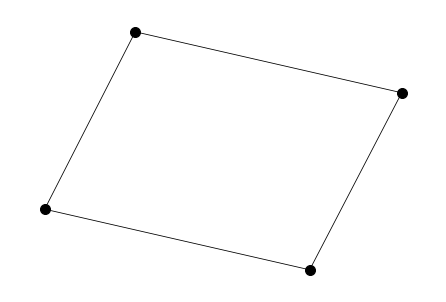

In [184]:
nx.draw(G1, node_size=100, node_color="black", width=0.8)

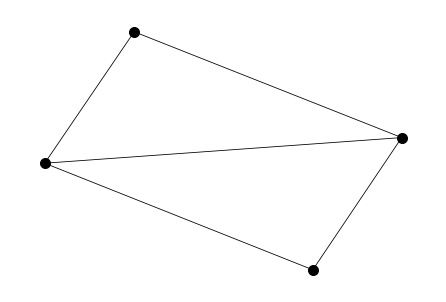

In [185]:
nx.draw(G2, node_size=100, node_color="black", width=0.8)

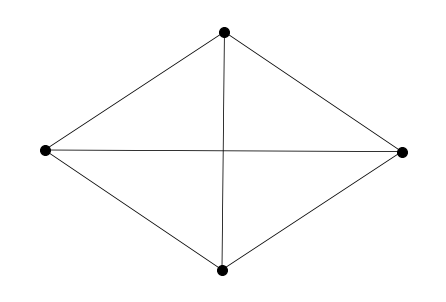

In [186]:
nx.draw(G3, node_size=100, node_color="black", width=0.8)

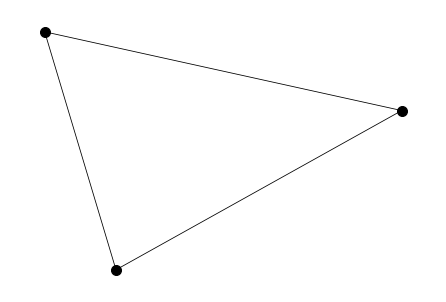

In [187]:
nx.draw(G4, node_size=100, node_color="black", width=0.8)